# abtract

Les prescriptions de médicaments comportent parfois des erreurs ou des risques potentiels qui nécessitent une intervention pharmaceutique (IP). Ce projet a pour objectif de développer deux modèles de classification pour prédire la nécessité et la nature de ces IPs, en se basant sur les commentaires de pharmaciens, selon les critères établis par la Société Française de Pharmacie Clinique. Le premier modèle est conçu pour prédire si une IP est classée comme « grave » ou « non-grave ». Le deuxième modèle vise à identifier la classe spécifique de l'IP parmi 11 catégories.

Les données utilisées proviennent des Hôpitaux Universitaires de Strasbourg. Après un prétraitement initial pour supprimer les lignes vides, deux colonnes cibles ont été créées à partir de la colonne 'PLT' : la première (IP_1) codifie la gravité de l'IP (1 pour « grave », 0 pour « non-grave »), tandis que la seconde (IP_2) correspond à la classe d'IP (de 1 à 11).

Pour le modèle de prédiction de gravité (modèle 1), un réseau de neurones séquentiel a été utilisé avec une couche d'embedding, une couche de pooling global, et une couche de sortie sigmoïde. Ce modèle a atteint une précision de 92 %, un score F1 de 0,79, et a bien distingué les interventions graves des non-graves, avec une matrice de confusion montrant une bonne détection des cas graves.  

Pour le modèle de classification des classes d'IP (modèle 2), un réseau de neurones avec une couche LSTM et une activation softmax a été employé. Ce modèle a obtenu une précision globale de 76 %, bien qu’il montre une performance variable selon les classes, avec une précision plus élevée pour les classes majoritaires. La performance de ce modèle est détaillée par classe, avec des scores F1 variant en fonction de la distribution des catégories dans les données.

Ce travail met en lumière un outil potentiel pour assister les pharmaciens dans l'évaluation des IPs, en intégrant des modèles de classification avancés pour une prise de décision éclairée et sécurisée.

# library

In [1]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, LSTM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
import random

# import data

In [2]:
lien_csv = "https://raw.githubusercontent.com/pierrebeguin/Master_2_defi_2/main/data_defi_2.csv"
response = requests.get(lien_csv)
data = pd.read_csv(StringIO(response.text), sep=";")

# supprimer la 1er ligne
data.columns = data.iloc[0]
data = data.iloc[1:].reset_index(drop=True)

# Suppression des lignes où la colonne 'Avis.Pharmaceutique' est vide
data = data.dropna(subset=['Avis.Pharmaceutique'])

# Créer les colonnes IP_1 et IP_2
data['PLT'] = pd.to_numeric(data['PLT'], errors='coerce')
data['IP_1'] = np.where(data['PLT'].isin([4.1, 4.2, 5.1, 5.2, 5.3, 6.3, 6.4]), 1, 0)
data['IP_2'] = np.floor(data['PLT']).astype(int)

data.head()
#data.groupby('IP_1').size()

,Libellé.Prescription,Avis.Pharmaceutique,PLT,IP_1,IP_2
0,"CONTRAMAL 100 MG/ML, GOUTTES BUV (TRAMADOL)",30/12/16 pas d'indication,5.3,1,5
1,"IMOVANE 7.5 MG, CPR SÉCABLE (ZOPICLONE)","22/12/16 recommandé -> IMOVANE 3,75MG CP, 1 au...",4.1,1,4
2,"COLCHICINE 1 MG, CPR SÉCABLE (COLCHICINE)","au vue de la DFG, il est recommandé d'administ...",4.1,1,4
3,"PANTOPRAZOLE 40 MG, CPR GASTRO-RÉSISTANT (EUPA...",Dose curative et absence d'ATCD gastrique retr...,4.1,1,4
4,VANCOMYCINE 500 mg 1x/j,posologie infraT veuillez réévaluer la posolog...,3.1,0,3


# Préparation_1

In [3]:
# Fixer les graines pour assurer la reproductibilité
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# définir X et y
X = data['Avis.Pharmaceutique']
y = data['IP_1']

# Divisez les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify=y)

# Paramètres de tokenisation
max_words = 10000
max_len = 100

# Initialiser le tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convertir les textes en séquences de tokens
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Ajouter du padding pour uniformiser la longueur des séquences
X_train = pad_sequences(X_train, padding='post')
X_test = pad_sequences(X_test, padding='post')

# Modèle_1

In [4]:
# Création du modèle de réseau de neurones
model_1 = Sequential([
    Embedding(input_dim=max_words, output_dim=16, input_length=max_len,
              embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    Dense(1, activation='sigmoid')
])


# Compilation du modèle
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
model_1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7941 - loss: 0.5127 - val_accuracy: 0.8047 - val_loss: 0.4456
Epoch 2/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8134 - loss: 0.4144 - val_accuracy: 0.8743 - val_loss: 0.2923
Epoch 3/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8682 - loss: 0.3042 - val_accuracy: 0.8907 - val_loss: 0.2570
Epoch 4/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8901 - loss: 0.2653 - val_accuracy: 0.9026 - val_loss: 0.2388
Epoch 5/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9019 - loss: 0.2395 - val_accuracy: 0.9071 - val_loss: 0.2269
Epoch 6/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9121 - loss: 0.2195 - val_accuracy: 0.9108 - val_loss: 0.2184
Epoch 7/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9183 - loss: 0.2037 - val_accuracy: 0.9166 - val_loss: 0.2121
Epoch 8/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9255 - loss: 0.1909 - val_accuracy: 0.9186 - val_

# Evaluation_1

In [5]:
# Prédictions sur les données de test
y_pred_proba = model_1.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype("int32").flatten()

# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Afficher les résultats
print(f"Accuracy : {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1 Score : {f1:.2f}")
print("\nMatrice de confusion :\n", conf_matrix)
print("\nClassification Report :\n", class_report)

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy : 0.92
Precision: 0.81
Recall   : 0.78
F1 Score : 0.80

Matrice de confusion :
 [[3559  164]
 [ 195  711]]

Classification Report :
               precision    recall  f1-score   support

           0       0.95      0.96      0.95      3723
           1       0.81      0.78      0.80       906

    accuracy                           0.92      4629
   macro avg       0.88      0.87      0.88      4629
weighted avg       0.92      0.92      0.92      4629



145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


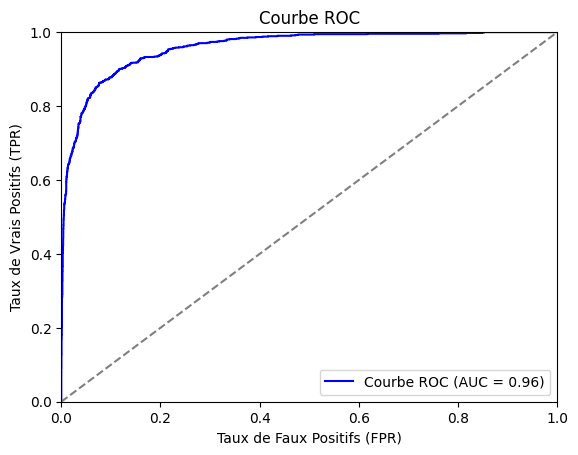

In [6]:
y_pred_proba = model_1.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

# Préparation_2

In [7]:
# Fixer les graines pour assurer la reproductibilité
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# définir X et y
X = data['Avis.Pharmaceutique']
y = data['IP_2']

# Divisez les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify=y)

# Paramètres de tokenisation
max_words = 10000
max_len = 100

# Initialiser le tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convertir les textes en séquences de tokens
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Ajouter du padding pour uniformiser la longueur des séquences
X_train = pad_sequences(X_train, padding='post')
X_test = pad_sequences(X_test, padding='post')

# Modèle_2

In [8]:
# Création du modèle de réseau de neurones
model_2 = Sequential()
model_2.add(Embedding(input_dim=max_words, output_dim=16, input_length=max_len,
                      embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=42)))
model_2.add(LSTM(64, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)))
model_2.add(GlobalAveragePooling1D())
model_2.add(Dense(12, activation='softmax', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)))


# Compilation du modèle
model_2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entraînement du modèle
model_2.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


579/579 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.5047 - loss: 1.6396 - val_accuracy: 0.5502 - val_loss: 1.2935
Epoch 2/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step - accuracy: 0.6369 - loss: 1.0925 - val_accuracy: 0.6580 - val_loss: 1.0710
Epoch 3/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.6940 - loss: 0.9387 - val_accuracy: 0.6913 - val_loss: 0.9414
Epoch 4/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.7445 - loss: 0.7760 - val_accuracy: 0.7187 - val_loss: 0.8667
Epoch 5/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.7891 - loss: 0.6524 - val_accuracy: 0.7295 - val_loss: 0.8424
Epoch 6/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - accuracy: 0.8224 - loss: 0.5564 - val_accuracy: 0.7434 - val_loss: 0.7929
Epoch 7/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.8435 - loss: 0.4897 - val_accuracy: 0.7516 - val_loss: 0.7880
Epoch 8/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 44s 42ms/step - accuracy: 0.8618 - loss: 0.4436 - val_accurac

# Evaluation_2

In [9]:
# Prédire sur l'ensemble de test
y_pred = model_2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Évaluation détaillée
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Classification Report:
              precision    recall  f1-score   support

           1       0.91      0.85      0.88      2253
           2       0.84      0.62      0.71       151
           3       0.28      0.37      0.32       194
           4       0.67      0.75      0.71       613
           5       0.38      0.57      0.46       166
           6       0.78      0.85      0.82       193
           7       0.00      0.00      0.00         2
           8       0.80      0.70      0.75       589
           9       0.00      0.00      0.00         4
          10       0.52      0.60      0.56       148
          11       0.55      0.58      0.56       316

    accuracy                           0.75      4629
   macro avg       0.52      0.54      0.52      4629
weighted avg       0.77      0.75      0.76      4629



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


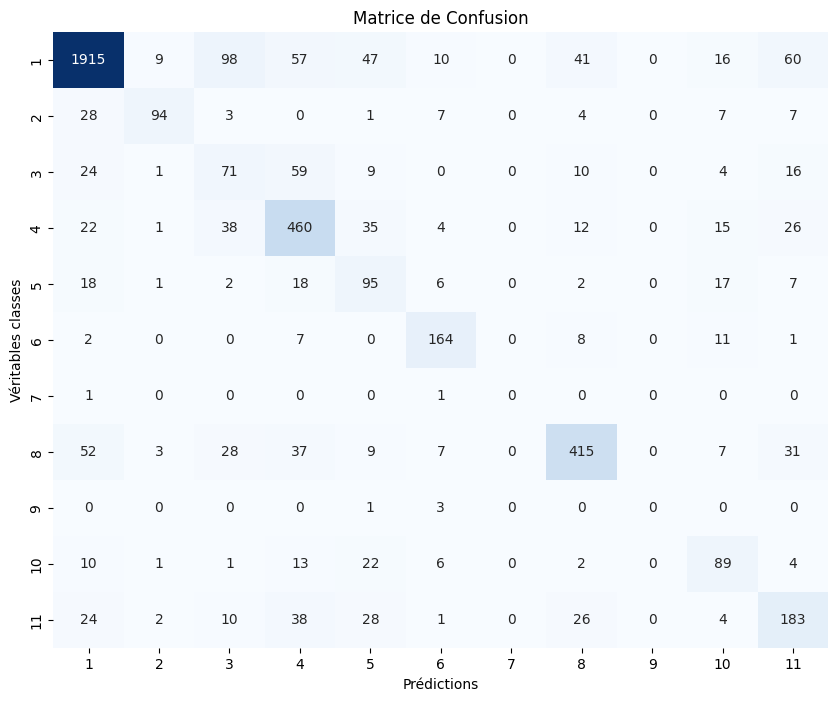

In [10]:
# Matrice de Confusion
conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=range(1, 12), yticklabels=range(1, 12))
plt.xlabel("Prédictions")
plt.ylabel("Véritables classes")
plt.title("Matrice de Confusion")
plt.show()

# data_test

In [11]:
lien_csv_test = "https://raw.githubusercontent.com/pierrebeguin/Master_2_defi_2/main/valid_set.csv"
response_test = requests.get(lien_csv_test)
data_test = pd.read_csv(StringIO(response_test.text), sep=";")

# Suppression des lignes où la colonne 'avis' est vide
data_test = data_test.dropna(subset=['Avis.Pharmaceutique'])

# Réinitialisez l'index
data_test = data_test.reset_index(drop=True)

#data_test.head()

In [12]:
### Fixer les graines pour assurer la reproductibilité
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

### Préparation

train = data_test['Avis.Pharmaceutique']
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train)
train = tokenizer.texts_to_sequences(train)
train = pad_sequences(train, padding='post')

### Model

y_pred_1 = model_1.predict(train)
y_pred_1 = (y_pred_1 > 0.5).astype("int32").flatten()

y_pred_2 = model_2.predict(train)
y_pred_2 = np.argmax(y_pred_2, axis=1)

### Résultat

y_pred_1 = pd.Series(y_pred_1, name="Statue")
y_pred_2 = pd.Series(y_pred_2, name="Classe")
result = pd.concat([data_test, y_pred_1, y_pred_2], axis=1)

### Afficher DataSet

display(result.head())
display(result.groupby('Statue').size())
display(result.groupby('Classe').size())

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


,Libellé.Prescription,Avis.Pharmaceutique,Statue,Classe
0,perf NEFOPAM 60 mg (Acupan) + 1.25 DROPERIDOL ...,ASSOCIATION CONTRE INDIQUEE : SEROPLEX 20 MG C...,0,6
1,"LAMALINE, GÉLULE",Propose arrêt pendant hospitalisation ou DOLIP...,0,1
2,"XYZALL 5 MG, CPR","Non référencé aux HUS, propose CETIRIZINE 10MG...",0,1
3,AMOXICILLINE + A.CLAVULANIQUE 1g x4/j (Augmentin),Il est recommandé de réduire la posologie en a...,0,1
4,"FELODIPINE LP 5 MG SANDOZ, CPR À LIBÉRATION PR...","Non référencé aux HUS, Substitué par amlodipin...",0,1


,0
Statue,
0,3841
1,233


,0
Classe,
1,2041
2,108
3,286
4,350
5,291
6,52
8,345
10,177
11,424


In [13]:
# Télécharger les résultats

result.to_csv('resultat_defi_2_beguin_pierre.csv', index=False, sep=";")
files.download('resultat_defi_2_beguin_pierre.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>